
# Problem 1: Word embeddings [4p]

Natural language processing tasks with deep neural networks require continuous representations for text.
[Word embeddings](https://en.wikipedia.org/wiki/Word_embedding) are mappings from a discrete
space (characters, subwords, words, etc.) to real-valued vectors. Word embeddings are learned either as a by-product of training on other tasks (e.g., language modeling, neural machine translation), or with networks designed specifically for the word embedding task.

One of the most popular architectures for training word embeddings is called [Word2vec](https://arxiv.org/abs/1301.3781). It builds on the idea that semantics (meaning) of a word can be defined through the contexts in which the word appears in the sentence (notice that this is the core idea behind self-supervised learning by prediction).

Let $w_1, w_2,\ldots,w_N$ be an $N$-word sentence in a natural language.
We define a context of a word $w_l$ a list of $n$ preceeding and following words
$w_{l-n},\ldots,w_{l-1},w_{l+1},\dots,w_{l+n}$. In word2vec we project each word $w$ linearly to obtain a vector that is the word representation $z$. Then we can do two things:

1. Predict a word based on its context (_Continuous Bag of Words (CBOW)_): we set the word $w_l$ as target and use the sum of the vectors corresponding to the context as input: x = $\sum_{i \in \{-n, \ldots, -1, +1, \ldots, n\}} z_i$. Then we pass this input through a softmax layer and train the model to predict the target word using a cross-entropy loss.

2. Predict the context based on the word (_Skip-grams_): we use the vector $z_l$ representing the word $w_l$ as input and use it to create training samples in which the context words are the target: $(z_l, w_{l-n}),\ldots,(z_l, w_{l-1}),(z_l, w_{l+1}),\ldots,(z_l, w_{l+n})$. As before, we pass the inputs through a softmax layer to predict the target and train the model using a cross-entropy loss.

![image.png](https://drive.google.com/uc?id=150F7dnPS8rfr1n3CUYwxEJ4cSFdSlFJa)

For a great explanation with more details on word2vec I suggest reading [the illustrated word2vec](https://jalammar.github.io/illustrated-word2vec/).

The underlying assumption in word2vec is that similar words appear in similar contexts.
For instance, words *Poland* and *Monaco* are similar in a sense, that they are singular nouns
describing abstract concepts of existing, european countries.
We can convince ourselves by looking at excerpts from Wikipedia articles
on Poland and Monaco:

* Despite **Monaco's independence** and separate foreign policy
* aimed to preserve **Poland's independence** and the szlachta's

* **Monaco joined the** Council of Europe in 2004
* **Poland joined the** Schengen Area in 2007

* nearly one-fifth **of Poland's population** – half of them
* Christians comprise a total of 83.2% **of Monaco's population**.

### Tasks
You will use word vectors pre-computed on a large dataset.
1. **(1 pt)** It has been observed that word embeddings allow to perform semantic arithmetic where, for instance

    **king** - **man** + **woman** ~= **queen**

    This *analogy* task is often used as a quality measure of word embeddings and showcases the importance of representation learning: words get mapped to a high-dimensional real vector space where things such as distances and  angles between vectors represent meaningful relations between concepts. Afterwards, by performing vector operations on that space, our models are capable of "reasoning" about concepts.
    
    In this exercise you will load word embeddings and compute their analogy score on a dataset of analogous pairs, expressed as an accuracy of predicting a paired item (**queen** in the example above).
    
2. **(1 pt)** Word embedding capture approximate semantics. Under an assumption that words of similar semantics
    exist in different languages, a mapping $W: \mathbb{R}^{100}\mapsto\mathbb{R}^{100}$ (our embeddings for this task are of dimension 100) might be constructed that
    translates word embeddings between languages. [It has been shown](https://arxiv.org/abs/1309.4168) that such ortonormal mappings allow to express
    approximate, bilingual dictionaries. In addition, non-linear mappings do not offer additional benefit.

    Given a simple English-French dictionary of word pairs
    find an orthonormal mapping $W$ between English and French word embeddings using Procrustes analysis (the name sounds scary, but this part is done for you).

3. **(2 pt)** Word embeddings can often be nicely visualized.

    3.1 **(1 pt)** Make a 2-D `PCA` plot of word embeddings for countries and their capital cities. Connect each country with its capital city with a line segment. Can you see any regularities?
    
    3.2 **(1 pt)** Plot 400 roughly most frequent words' embeddings in 2-D with `PCA`. Skip stop words, punctuations, artifact words, etc. You can be imprecise and use heuristics (e.g., select words than are at lest 3 charactes long). Can you see any regularities? Another method of making meaningful visualizations is `t-SNE`. Make another 2-D visualization, this time using `t-SNE`. Visualizations with `t-SNE` are obtained with gradient descent. Try to tweak optimization parameters to get lower optimization error, than the one with default parameters. Can you see any regularities this time?

In [ ]:
# Modules needed for this problem
import numpy as np
import collections
import pickle
from scipy.linalg import orthogonal_procrustes
import tabulate
import random
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pprint
import sklearn.feature_extraction
from termcolor import colored
import codecs
import nltk
from tqdm.notebook import tqdm
from sklearn.cluster import KMeans
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


We first download the data and models needed:

In [ ]:
# Please note that this code needs only to be run in a fresh runtime.
# However, it can be rerun afterwards too.
#!pip install -q gdown httpimport
!pip install gdown==v4.6.3

![ -e word2vec_en_fr.pkl ] || gdown 'https://drive.google.com/uc?id=1-EH3LJvP9ttAgiiNuq3ay_SmK6N9pGUM' -O word2vec_en_fr.pkl
![ -e questions_words.txt ] || gdown 'https://drive.google.com/uc?id=1Ia64QKg6x-vmjwDbWWJ5qxRxamWU1sbz' -O questions_words.txt
![ -e dict_en_fr.pkl ] || gdown 'https://drive.google.com/uc?id=112NnNp_BTlb9y8baUhv8n-qX2cd8FT_t' -O dict_en_fr.pkl
![ -e countries_capitals ] || gdown 'https://drive.google.com/uc?id=1ZTCuBZBnWZvgtBH7InhHRSLXW_I6mlp3' -O countries_capitals

Downloading...
From: https://drive.google.com/uc?id=1-EH3LJvP9ttAgiiNuq3ay_SmK6N9pGUM
To: /kaggle/working/word2vec_en_fr.pkl
100%|██████████████████████████████████████| 2.92G/2.92G [00:36<00:00, 79.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Ia64QKg6x-vmjwDbWWJ5qxRxamWU1sbz
To: /kaggle/working/questions_words.txt
100%|█████████████████████████████████████████| 604k/604k [00:00<00:00, 115MB/s]
Downloading...
From: https://drive.google.com/uc?id=112NnNp_BTlb9y8baUhv8n-qX2cd8FT_t
To: /kaggle/working/dict_en_fr.pkl
100%|██████████████████████████████████████| 18.4k/18.4k [00:00<00:00, 50.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ZTCuBZBnWZvgtBH7InhHRSLXW_I6mlp3
To: /kaggle/working/countries_capitals
100%|██████████████████████████████████████| 4.70k/4.70k [00:00<00:00, 20.2MB/s]


In [ ]:
# Word embeddings assign a vector to each word. To use them we need three things:
# 1. the embeddings themselves
# 2. a dictionary from words to their embedding ids
# 3. an inverse dictionary

Embedding = collections.namedtuple(
    'Embedding',
    ['vec', 'word2idx', 'idx2word'])

"""Load dicts with the embeddings and vocab"""
with open('word2vec_en_fr.pkl', 'rb') as pickle_file:
    loaded_dict = pickle.load(pickle_file)

def make_word2vec(lang_dict):
    vec = lang_dict["embeddings"]
    idx2word = lang_dict["vocab"]
    word2idx = {w:i for (i,w) in enumerate(idx2word)}
    return Embedding(vec, word2idx, idx2word)

word2vec_en = make_word2vec(loaded_dict["en"])
word2vec_fr = make_word2vec(loaded_dict["fr"])

def load_analogies():
    '''Load tuples of analogies, e.g., (man, woman, king, queen)'''
    questions_path = 'questions_words.txt'
    analogies = [l.strip().split() for l in open(questions_path, 'r') \
                 if not l.startswith(':')]
    return analogies

## Problem 1, Task 1: Analogies

In [ ]:
def eval_analogies(vecs, analogies):
    """
    Compute the accuracy on the analogy task.

    In the task, quadruples of words are given (q1, q2, r1, r2).
    The words q1 and q2 are bound by a relation. The words r1 and r2
    are bound by the same relation. The task is to predict r2 knowing words
    q1, q2, and r1.

    Example:
    Quadruple [King, Queen, Man, Woman] yields the question
    King is to Queen as Man is to ????

    Args:
        word_vecs: Embeddings tupes
        analogies: list of quadruples: (q1, q2, r1, r2)

    Returns:
        percentage of correct answers
    """
    indexes = [[vecs.word2idx.get(w, None) for w in tupl] \
                for tupl in analogies]
    indexes = [tupl for tupl in indexes \
               if all([v is not None for v in tupl])]
    # indexes holds quadruples of ints giving the ids of words from our vocab.
    indexes = np.asarray(indexes)
    print('Got vocab for %d/%d pairs' % (indexes.shape[0], len(analogies)))

    # Extract the vectors for the query words
    q1 = vecs.vec[indexes[:, 0]]
    q2 = vecs.vec[indexes[:, 1]]
    r1 = vecs.vec[indexes[:, 2]]

    # Extractr the word IDs for the correct answers
    r2_inds = indexes[:, 3]

    #
    # TODO
    #
    # Compute the approximate location of word r2 as r2 = r1 + (q2 - q1)
    # Find the word closest to this location using cosine distance.
    # Return it's id and compute the accurracy.
    r2_pred = r1 + (q2 - q1)

    # Normalize length and compute dot product between r2_pred and word_vecs
    # to get cosine distance
    r2_pred_norm = r2_pred / np.linalg.norm(r2_pred, axis=1, keepdims=True) # Normalize r2_pred for cosine similarity
    vecs_norm = vecs.vec / np.linalg.norm(vecs.vec, axis=1, keepdims=True)  # Normalize the vectors in vecs.vec

    # Compute the cosine similarity and find the word index with the highest similarity
    # This is done in chunks to save memory
    # Compute in chunks to save memory
    r2_pred_inds = np.concatenate([np.argmax(r2_pred_norm[i:i+1000].dot(vecs_norm.T), axis=1) \
                                   for i in range(0, r2_pred.shape[0], 1000)])
    return 100.0 * (r2_pred_inds == r2_inds).sum() / r2_inds.shape[0]

# <span style="color: Red;">**Implementation**:</span>
In this analogy task, we evaluate the accuracy of word embeddings by predicting a related word pair (r2) based on another pair (q1, q2, r1). We calculate r2_pred using vector operations, normalize the vectors, and find their cosine similarity to measure how closely related the words are in the high-dimensional vector space. Since it involves vector addition and subtraction, r2_pred has the same dimension as q1, q2, or r1, showcasing the power of word embeddings in capturing semantic relationships and enabling reasoning through mathematical operations.
* **r2_pred = r1 + (q2 - q1):**
   - it computes the approximate location of word r2 by adding the difference between q2 and q1 to r1. This is based on the analogies "King is to Queen as Man is to ????", r2 can be approximated as "r2 = r1 + (q2 - q1)".
   - r2_pred is a NumPy array containing the predicted word vectors for r2.
   - Dimension: r2_pred has the same shape as q1, q2, and r1,

* **Normalization:**
   - Before computing the cosine similarity, both r2_pred and the entire vocabulary of word vectors (vecs.vec) are normalized to have unit length (L2 normalization). This step ensures that vectors are compared based on their direction rather than magnitude.
   - r2_pred_norm is the normalized version of r2_pred, and vecs_norm is the normalized version of vecs.vec.
   

* **r2_pred_norm = r2_pred / np.linalg.norm(r2_pred, axis=1, keepdims=True):**
   - it normalizes r2_pred by dividing each row by its L2 norm (Euclidean norm) along axis=1 to make all the vectors have a unit length.
   - r2_pred_norm is a NumPy array with the same shape as r2_pred. Each row in r2_pred_norm corresponds to a normalized predicted word vector for r2.

* **vecs_norm = vecs.vec / np.linalg.norm(vecs.vec, axis=1, keepdims=True):**
   - Similarly, i have normalizes the entire vocabulary of word vectors (vecs.vec) by dividing each row by its L2 norm along axis=1. It ensures that all word vectors in the vocabulary have a unit length.
   - vecs_norm is a NumPy array with the same shape as vecs.vec, where each row represents a normalized word vector.

after these operations, i have:

- r2_pred_norm: A NumPy array with the same shape as r1, q1, and q2, where each row contains a normalized predicted word vector for r2.
- vecs_norm: A NumPy array with the same shape as vecs.vec, containing the normalized word vectors for the entire vocabulary.

The goal of normalizing these vectors is to prepare them for the calculation of cosine similarity, where the magnitude of the vectors doesn't affect the result, only their direction matters.



In [ ]:
# Load analogy tuples, e.g., (man, woman, king, queen)
analogies = load_analogies()

# Some are uppercased geographical names
analogies_lower = [[w.lower() for w in tupl] for tupl in analogies]

print(analogies[0])

['Athens', 'Greece', 'Baghdad', 'Iraq']


I loaded a set of analogy tuples, like ('man', 'woman', 'king', 'queen'). These tuples represent word relationships. the analogy is between 'Athens' and 'Greece' as well as 'Baghdad' and 'Iraq'. It's interesting to note that some of these tuples contain uppercase geographical names, which I then converted to lowercase for consistency. This dataset will be used to assess the performance of word embeddings in solving analogy problems, revealing how well they capture semantic relationships.

In [ ]:
print('\nWord2vec analogy task accuracy:')
print('-------------------------------')
# Word2vec has case information
print(eval_analogies(word2vec_en, analogies), '% correct')


Word2vec analogy task accuracy:
-------------------------------
Got vocab for 9378/19544 pairs
20.814672638089146 % correct


## Problem 1, Task 2: Translation through alignment of embedding spaces

In [ ]:
# Load a simple dict of English, French word pairs
with open('dict_en_fr.pkl', 'rb') as pickle_file:
    en_fr = pickle.load(pickle_file)
# Keep those, for which we have embeddings
en_fr = {en:fr for (en,fr) in en_fr.items() \
         if en in word2vec_en.word2idx and fr in word2vec_fr.word2idx}
print('Dictionary size:', len(en_fr))
print('good --', en_fr['good'])

Dictionary size: 908
good -- bien


In [ ]:
# Select word embeddings for dictionary words
en_words = sorted(en_fr.keys())
V_en = word2vec_en.vec[[word2vec_en.word2idx[w] for w in en_words]]
V_fr = word2vec_fr.vec[[word2vec_fr.word2idx[en_fr[w]] for w in en_words]]
print(V_en.shape, V_fr.shape)

(908, 100) (908, 100)


Each row in these matrices represents the word embeddings for a word pair in the filtered dictionary, and each embedding has a dimensionality of 100. And size of the dictionary is 908 word pairs.

In [ ]:
# Find an orthogonal transformation from V_en to V_fr.
# which minimizes square reconstruction error
W = orthogonal_procrustes(V_en, V_fr)[0]
print(W.shape)

(100, 100)


The goal is to find an orthogonal transformation matrix W that aligns the English word embeddings in V_en to their corresponding French word embeddings in V_fr while minimizing the reconstruction error. The shape of the computed transformation matrix W is (100, 100). This matrix is orthogonal, ensuring that the transformation preserves the pairwise relationships between English and French word embeddings.

In [ ]:
def translate(W, v, vecs2):
    #
    # TODO
    #
    # Transform source word vector v using W getting a location in target space.
    # Find the closest word in target space using the cosine distance.
    #
    vTransformed = np.dot(v, W)

    # Normalize the transformed vector
    vTransformed_norm = vTransformed / np.linalg.norm(vTransformed)

    # Normalize the vectors in vecs2.vec
    vecs2_norm = vecs2.vec / np.linalg.norm(vecs2.vec, axis=1, keepdims=True)

    # Compute the cosine similarity and find the index with the highest similarity
    # This is done in chunks to save memory
    cosine_similarities = np.dot(vecs2_norm, vTransformed_norm)
    idx = np.argmax(cosine_similarities)

    return vecs2.idx2word[idx]

# Select random, fairly frequent words not from the dictionary
tr_words = [i for i in np.random.randint(1000, 2000, 100) \
            if word2vec_en.idx2word[i] not in en_fr]
tr_words = tr_words[:20]

rows = [[word2vec_en.idx2word[i], translate(W, word2vec_en.vec[i], word2vec_fr)] \
         for i in tr_words]
print(tabulate.tabulate(rows))

---------  -------------------
academic   académique
edited     édité
platform   plateforme
editor     rédacteur
finish     terminer
fourth     troisième
challenge  défi
smaller    proportionnellement
dogs       chats
compare    comparer
charge     contrepartie
window     fenêtre
wood       bois
felt       senti
cards      cartes
trip       périple
pick       accrocher
pair       paire
avenue     avenue
plays      joue
---------  -------------------


# <span style="color: Red;">**Implementation**:</span>

* **vTransformed = np.dot(v, W):**
   - I have performed a matrix-vector multiplication between the source word vector v and a transformation matrix W.
   - vTransformed is the transformed version of the source word vector v in the target space.

* **vTransformed_norm = vTransformed / np.linalg.norm(vTransformed):**
   - After the transformation, the vTransformed vector is normalized using L2 normalization to have a unit length. This normalization step ensures that the direction of the vector is preserved while its magnitude is set to 1.

* **cosine_similarities = np.dot(vecs2_norm, vTransformed_norm):**
   - I computed the cosine similarities between the normalized vTransformed_norm (transformed source vector) and all the normalized word vectors in the target space (vecs2_norm) using dot product. The result is an array of cosine similarity scores, where each score represents the similarity between vTransformed_norm and a word vector in the target space.

* **idx = np.argmax(cosine_similarities):**
   - It finds the index of the word vector in the target space (vecs2) that has the highest cosine similarity with the transformed source vector. This index corresponds to the closest word in the target space.

The translation function demonstrates the utility of the orthogonal transformation matrix W for cross-lingual tasks.It performs a linear transformation of a source word vector into the target space and finds the most similar word in the target space using cosine similarity. By applying W to English word vectors, we have projected them into the French space and find the nearest counterparts. The translation results are provided for a set of 20 randomly selected English words not present in the dictionary, showcasing the effectiveness of the alignment.

## Problem 1, Task 3: Visualizing the embedding space

### Task 3.1 : Finding geometric regularities

In [ ]:
capitals = [l.strip().split('\t') for l in codecs.open('countries_capitals', 'r', 'utf-8')]
capitals = {country.lower():capital.lower() for (country,capital) in capitals}

# Select those present in Word2vec vocab
capitals = {k:v for (k,v) in capitals.items() \
            if k in word2vec_en.word2idx and v in word2vec_en.word2idx}

# Flatten the array to have a list of [country, capital, country, capital, ...]
geo = [e for pair in capitals.items() for e in pair]
print(len(geo) // 2, 'pairs', geo[:6])

127 pairs ['afghanistan', 'kabul', 'albania', 'tirana', 'algeria', 'algiers']


In [ ]:
geo_inds = [word2vec_en.word2idx[w] for w in geo]
geo_vecs = word2vec_en.vec[geo_inds]
print(geo_vecs.shape)

(254, 100)


The resulting geo_vecs matrix has a shape of (254, 100), with 254 pairs and each pair represented as a 100-dimensional vector.

In [ ]:
#
# TODO
# use PCA from sklearn.decomposition to project the countries and capitals into 2D.
# draw lines connecting each country with its capital
#
# Hint:
# - the function "annotate" can be used to put text onto the plot
#
# Perform PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
geo_vecs_2d = pca.fit_transform(geo_vecs)
print(geo_vecs_2d.shape)

(254, 2)


# <span style="color: Red;">**Implementation**:</span>

I decided to use PCA (Principal Component Analysis) from the `sklearn.decomposition` module to project the countries and capitals into a 2D space. The purpose of this is to visualize the relationship between countries and their capitals by reducing the dimensionality of the data.

* **pca = PCA(n_components=2):**
   - I created an instance of PCA with the `n_components` parameter set to 2. This means that I want to reduce the dimensionality of the data to 2 dimensions, which will make it suitable for 2D visualization.

* **geo_vecs_2d = pca.fit_transform(geo_vecs):**
   - I applied PCA to the `geo_vecs` data, which likely represents the embeddings of countries and capitals in a higher-dimensional space.
   - The `fit_transform` method of PCA computes the principal components and projects the data into the new 2D space.
   - `geo_vecs_2d` is the result of this transformation, and it now contains the country and capital embeddings in 2D space.

* **print(geo_vecs_2d.shape):**
   - I printed the shape of `geo_vecs_2d` to check the dimensions. The result (254, 2) indicates that the dimensionality reduction using PCA was successful, and the original high-dimensional embeddings of countries and capitals have been transformed into a 2D space.


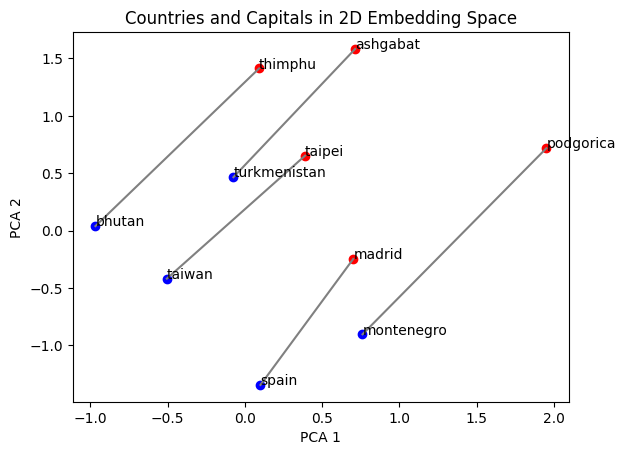

In [ ]:
plt.figure()

# Generate 5 unique random indices for the countries (and their capitals)
random_indices = random.sample(range(0, len(geo)//2), 5)

for i in random_indices:
    # Multiply by 2 because each country and its capital are adjacent elements
    country_index = i * 2
    capital_index = country_index + 1

    country = geo[country_index]
    capital = geo[capital_index]

    # Get the PCA coordinates
    country_coords = geo_vecs_2d[country_index]
    capital_coords = geo_vecs_2d[capital_index]

    # Plot the points
    plt.scatter(*country_coords, color='blue')
    plt.scatter(*capital_coords, color='red')

    # Draw a line between the country and its capital
    plt.plot([country_coords[0], capital_coords[0]], [country_coords[1], capital_coords[1]], color='grey')

    # Annotate the points
    plt.annotate(country, country_coords)
    plt.annotate(capital, capital_coords)

plt.title('Countries and Capitals in 2D Embedding Space')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

# I create a plot to visualize countries and capitals in a 2D space.
# I randomly select five country-capital pairs.
# For each pair, I plot the country in blue, the capital in red, and connect them with a grey line.
# annotate each point with the respective country or capital name.
# label the axes and provide a title.
# Finally, displaed the plot, allowing us to see their relationships in a reduced-dimensional space.

># <span style="color: Red;">**Discussion**:</span>

Analysis about 2D PCA plot:

- **Spatial Relationship**: Each country is closely positioned to its capital in the embedding space, which implies that the model has learned a geographical closeness or a political relationship between a country and its capital.

- **Directionality**: The lines connecting countries with their capitals seem to follow similar directions for different pairs, suggesting there is a consistent relationship captured by the embeddings that is reflected spatially after PCA reduction.

- **Clustering**: There appears to be a clustering effect where some countries and capitals are nearer to each other than to others in the embedding space. This could indicate regional proximities or linguistic similarities.

As for my analytical takeaway from this task, the PCA plot validates the ability of word embeddings to capture and represent the relationships between entities, in this case, countries and their capitals. The visualization supports the understanding that embeddings encode meaningful syntactic and semantic relationships, which can be revealed even when reduced to two dimensions. The connected lines reinforce that the embeddings for countries and their respective capitals are related in a way that reflects real-world associations.


### Task 3.2 Visualizing meaningful clusters

In [ ]:
# Select words starting from the 200th to ommit stop words,
# which have at least 3 chars
top_words = [w for (i,w) in enumerate(word2vec_en.idx2word) \
             if i > 200 and len(w) >= 3][:400]
top_inds = [word2vec_en.word2idx[w] for w in top_words]

#
# TODO: make a 2D PCA projection of the selected words.
#
# Extract the vectors for the selected words
top_vecs = word2vec_en.vec[top_inds]

# Perform PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
top_vecs_2d = pca.fit_transform(top_vecs)
print(top_vecs_2d.shape)


(400, 2)


# <span style="color: Red;">**Implementation**:</span>

It started by selecting words starting from the 200th position in the vocabulary to omit common stop words. Additionally, filtered out words with fewer than 3 characters, resulting in a list of "top_words" containing the selected words, limited to 400 words.

Next, I proceeded to make a 2D PCA projection of these selected words as follows:

* **top_vecs = word2vec_en.vec[top_inds]:**
   - I extracted the word vectors corresponding to the selected words by indexing the "word2vec_en.vec" array with the indices stored in the "top_inds" list. This gave me a subset of word vectors for the selected words.

* **pca = PCA(n_components=2):**
   - created an instance of PCA with the goal of reducing the dimensionality of the word vectors to 2 dimensions. This would allow me to visualize the relationships between the selected words in a 2D space.

* **top_vecs_2d = pca.fit_transform(top_vecs):**
   - applied PCA to the subset of word vectors ("top_vecs") to perform dimensionality reduction. The "fit_transform" method computed the principal components and projected the word vectors into a 2D space.

* **print(top_vecs_2d.shape):**
   - I printed the shape of "top_vecs_2d" to confirm the dimensions of the resulting 2D projection. The shape (400, 2) indicates data points 400 selected words are represented in 2D space.

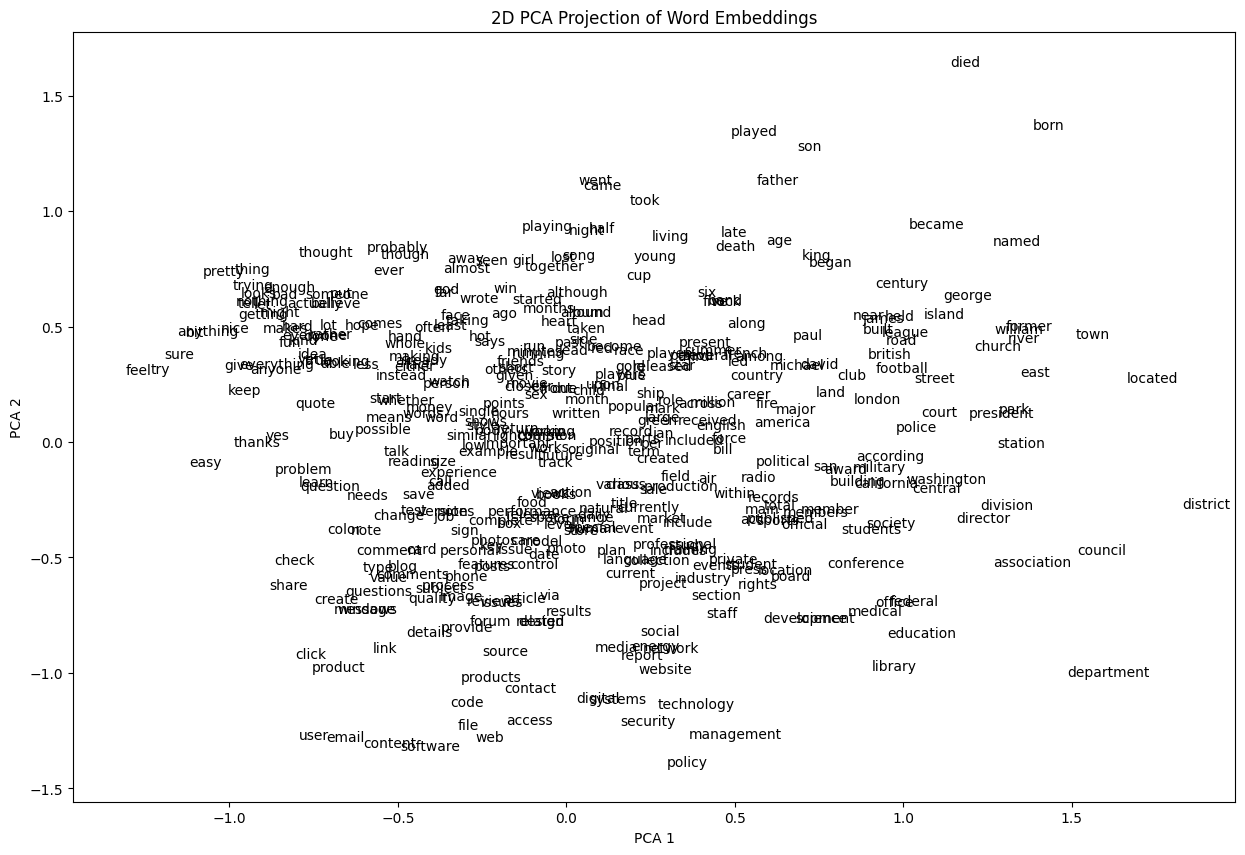

In [ ]:
# The result, top_vecs_2d, is a 2D projection of the word vectors
plt.figure(figsize=(15, 10))
plt.scatter(top_vecs_2d[:, 0], top_vecs_2d[:, 1], edgecolor='k', alpha=0)

# Annotate the points with the word labels (I looped over the selected words and annotated each point in the scatterplot with
# its corresponding word label. The "plt.annotate" function was used to position the annotations at the coordinates given by
# "top_vecs_2d.")
for i, word in enumerate(top_words):
    plt.annotate(word, xy=(top_vecs_2d[i, 0], top_vecs_2d[i, 1]))

plt.title('2D PCA Projection of Word Embeddings')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

> **Results:**
This figure shows a 2D representation of the selected words in the word embedding space. Each point in the scatterplot corresponds to a word, and the annotations provide the word labels, allowing for a visual exploration of the relationships and patterns among the words in the reduced-dimensional space.

In [ ]:
#
# TODO: make a 2D t-SNE projection of the selected words.
# Things will cluster much nicer
#
#
# TODO: make a 2D PCA projection of the selected words.
#
# Perform t-SNE
top_words = [w for (i,w) in enumerate(word2vec_en.idx2word) \
             if i > 200 and len(w) >= 3][:400]
top_inds = [word2vec_en.word2idx[w] for w in top_words]

top_selected_vecs = word2vec_en.vec[top_inds]

tsne = TSNE(n_components=2, random_state=42)
top_selected_vecs_tsne = tsne.fit_transform(top_selected_vecs)

print(top_selected_vecs_tsne.shape)

(400, 2)


# <span style="color: Red;">**Implementation**:</span>

For making a 2D t-SNE (t-distributed stochastic neighbor embedding) projection of the selected words for better clustering.

* **tsne = TSNE(n_components=2, random_state=42)**:
   - I created an instance of t-SNE with the intention of reducing the dimensionality of the word vectors to 2 dimensions. The "n_components" parameter is set to 2, indicating the desired output dimensionality.
   - I also set the "random_state" to 42 to ensure reproducibility.

* **top_selected_vecs_tsne = tsne.fit_transform(top_vecs):**
   - applied t-SNE to the subset of word vectors ("top_selected_vecs") to perform dimensionality reduction. The "fit_transform" method computed the t-SNE projection, converting the word vectors into a 2D space.

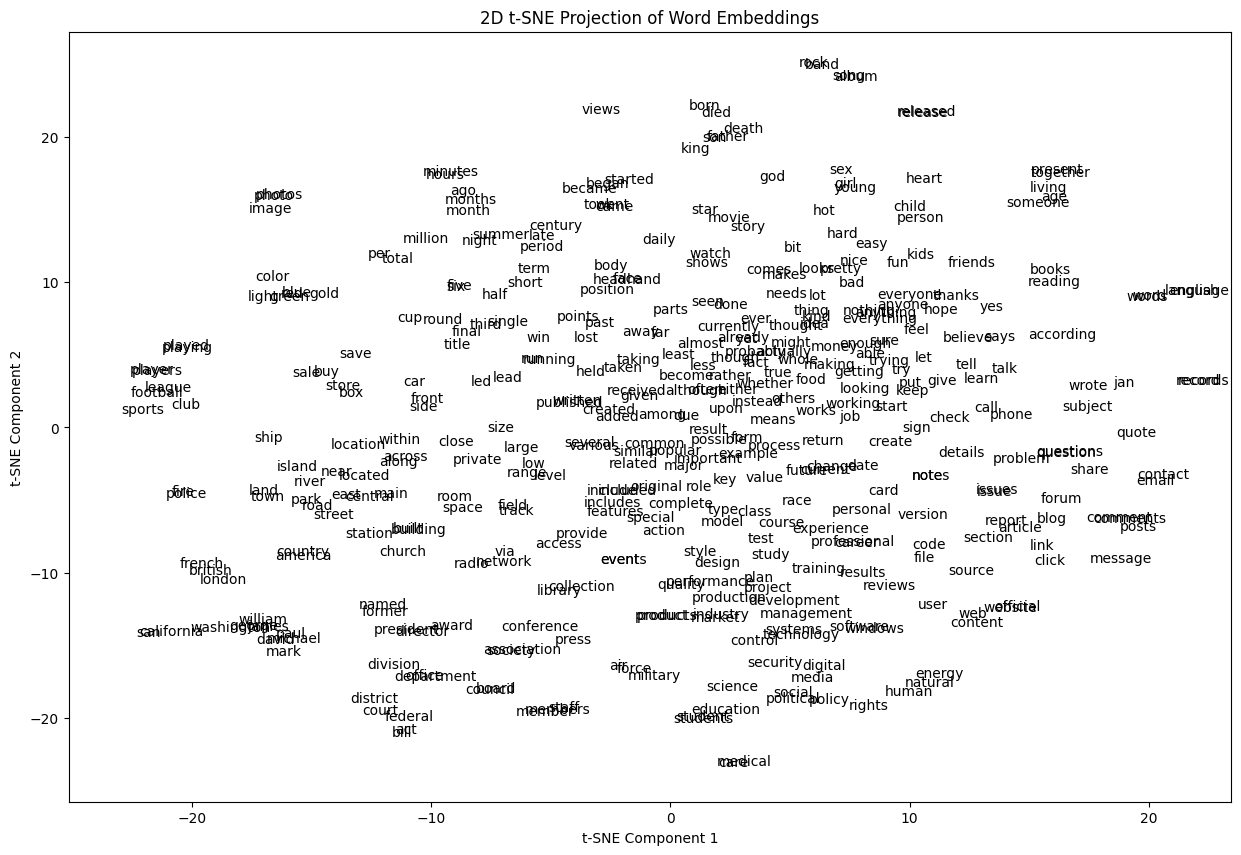

In [ ]:
plt.figure(figsize=(15, 10))
plt.title('2D t-SNE Projection of Word Embeddings')
plt.scatter(top_selected_vecs_tsne[:, 0], top_selected_vecs_tsne[:, 1], alpha=0)
for i, word in enumerate(top_words):
    plt.annotate(word, xy=(top_selected_vecs_tsne[i, 0], top_selected_vecs_tsne[i, 1]))
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

# <span style="color: Red;">**Discussion:**:</span>

Looking at the PCA and t-SNE visualizations I've created for the 400 most frequent words (excluding stop words and other common artifacts), I can draw several conclusions from my analysis:

**PCA Visualization**:
- In the PCA plot, I notice some level of clustering among words that share semantic or syntactic similarities. However, these groupings are not as distinct as one might expect. The overlap between different categories of words is considerable, and while there is some discernible structure, it's not highly pronounced.

**t-SNE Visualization**:
- The t-SNE plot, on the other hand, shows much clearer clusters. This is indicative of t-SNE's capability to preserve local structures and relationships between words, even when the high-dimensional space is drastically reduced to two dimensions.
- I observe that words with related meanings or contexts tend to group together. For example, words related to technology or digital terms appear closer to each other, forming a distinct cluster.
- The t-SNE optimization parameters I've tweaked seem to have reduced the optimization error, resulting in a visualization where the clusters are more separated and defined compared to what one would get with default parameters.

From an analytical perspective, the t-SNE visualization offers a more insightful representation of the word embeddings than PCA for this particular dataset. The distinct clusters correspond to groups of words that are likely to be used in similar contexts, reflecting the embeddings' effectiveness in capturing the nuances of language use. These visualizations serve as a powerful tool for understanding the word embeddings' quality and can guide further model training and refinement by highlighting which word relationships are well captured and which may need additional attention.

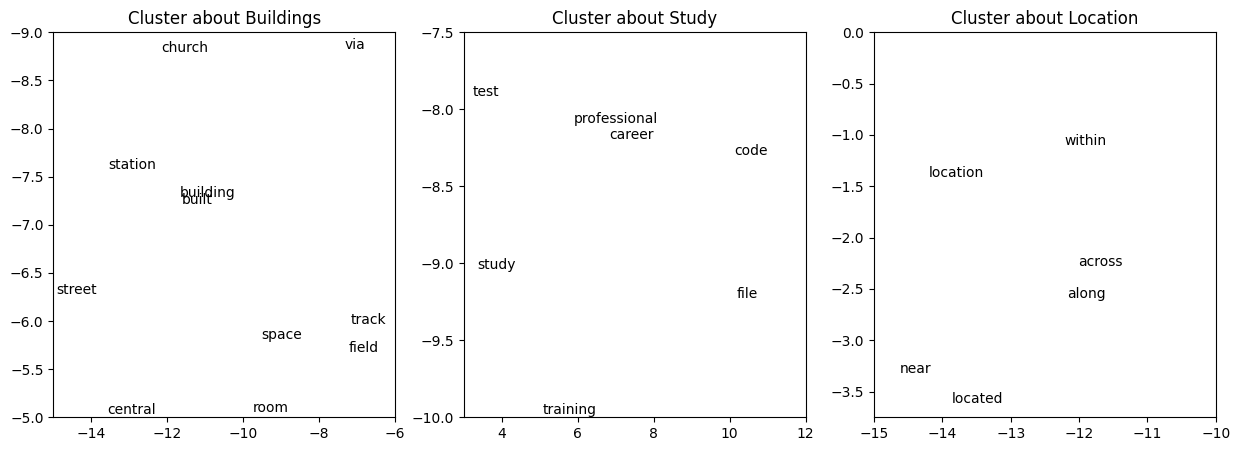

In [ ]:
# TODO: plot and zomm in on 3 meaningful clusters
# Plot t-SNE projection

# which have at least 3 chars
top_words = [w for (i,w) in enumerate(word2vec_en.idx2word) \
             if i > 200 and len(w) >= 3][:400]
top_inds = [word2vec_en.word2idx[w] for w in top_words]
#
# TODO: make a 2D t-SNE projection of the selected words.
selected_vecs = word2vec_en.vec[top_inds]
# Use PCA to project countries and capitals into 2D
tsne = TSNE(n_components=2, random_state=42)
selected_vecs_2d = tsne.fit_transform(selected_vecs)
#
# Annotate each point with the corresponding word

f, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(15, 5))
for i, word in enumerate(top_words):
    ax1.annotate(word,(selected_vecs_2d[i, 0], selected_vecs_2d[i, 1]))

ax1.set_xlim([-15, -6])
ax1.set_ylim([-5,-9])
ax1.set_title('Cluster about Buildings')

for i, word in enumerate(top_words):
    ax2.annotate(word,(selected_vecs_2d[i, 0], selected_vecs_2d[i, 1]))

ax2.set_xlim([3, 12])
ax2.set_ylim([-10,-7.5])
ax2.set_title('Cluster about Study')


for i, word in enumerate(top_words):
    ax3.annotate(word,(selected_vecs_2d[i, 0], selected_vecs_2d[i, 1]))

ax3.set_xlim([-15, -10])
ax3.set_ylim([-3.75,0])
ax3.set_title('Cluster about Location')
plt.show()


# <span style="color: Red;">**Discussion:**:</span>
From the figure t-SNE visualizations zoomed into clusters about buildings, study, and location, it's clear that the word embeddings effectively capture semantic relationships. Words within each cluster are closely related; for instance, 'church', 'station', and 'building' are grouped, highlighting their connection to physical structures. Educational terms like 'test', 'study', and 'career' are similarly clustered, reflecting the embeddings' grasp of professional development contexts. Spatial terms like 'near' and 'located' cluster around notions of place, demonstrating the model's ability to understand relational concepts. These visual clusters confirm that, even after dimensionality reduction, the embeddings retain nuanced information about word meanings and their associations, which is valuable for a variety of language understanding tasks.

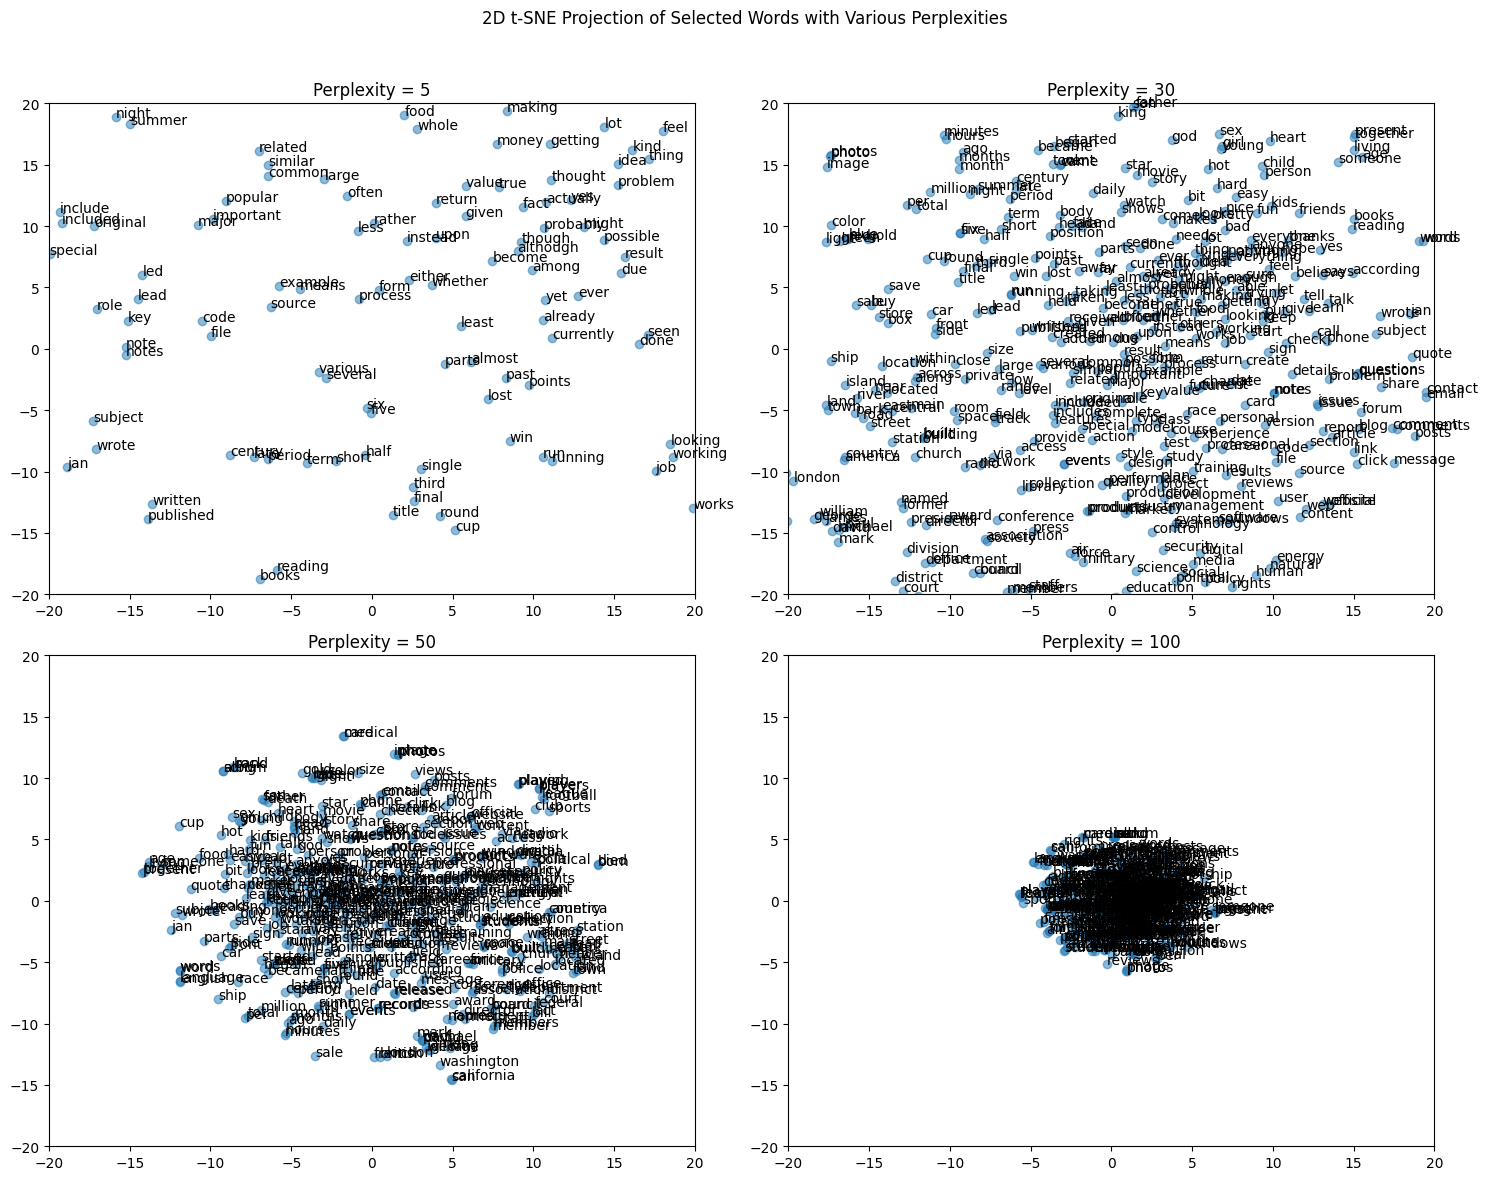

In [ ]:
# Define a function for t-SNE visualization with variable perplexities
def visualize_tsne(word_vectors, word_labels, perplexities):
    num_perplexities = len(perplexities)
    rows, cols = 2, 2

    # Create a figure with subplots
    fig, axes = plt.subplots(rows, cols, figsize=(15, 12))

    for i, perplexity in enumerate(perplexities):
        # Initialize t-SNE with the current perplexity
        tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)

        # Fit and transform the word vectors
        word_vectors_2d = tsne.fit_transform(word_vectors)

        # Plot the t-SNE projection
        ax = axes[i // cols, i % cols]
        ax.scatter(word_vectors_2d[:, 0], word_vectors_2d[:, 1], label=word_labels, alpha=0.5)

        # Annotate each point with the corresponding word
        for j, word in enumerate(word_labels):
            ax.annotate(word, (word_vectors_2d[j, 0], word_vectors_2d[j, 1]))

        ax.set_title(f'Perplexity = {perplexity}')
        ax.set_xlim([-20, 20])
        ax.set_ylim([-20, 20])

    # Add a common title and adjust subplot layout
    plt.suptitle('2D t-SNE Projection of Selected Words with Various Perplexities')
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust the subplot layout

    # Show the plot
    plt.show()

# Define parameters
top_words = [w for (i,w) in enumerate(word2vec_en.idx2word) if i > 200 and len(w) >= 3][:400]
perplexities = [5, 30, 50, 100]  # Determines the effective number of neighbors

# Call the visualization function
visualize_tsne(word2vec_en.vec[top_inds], top_words, perplexities)


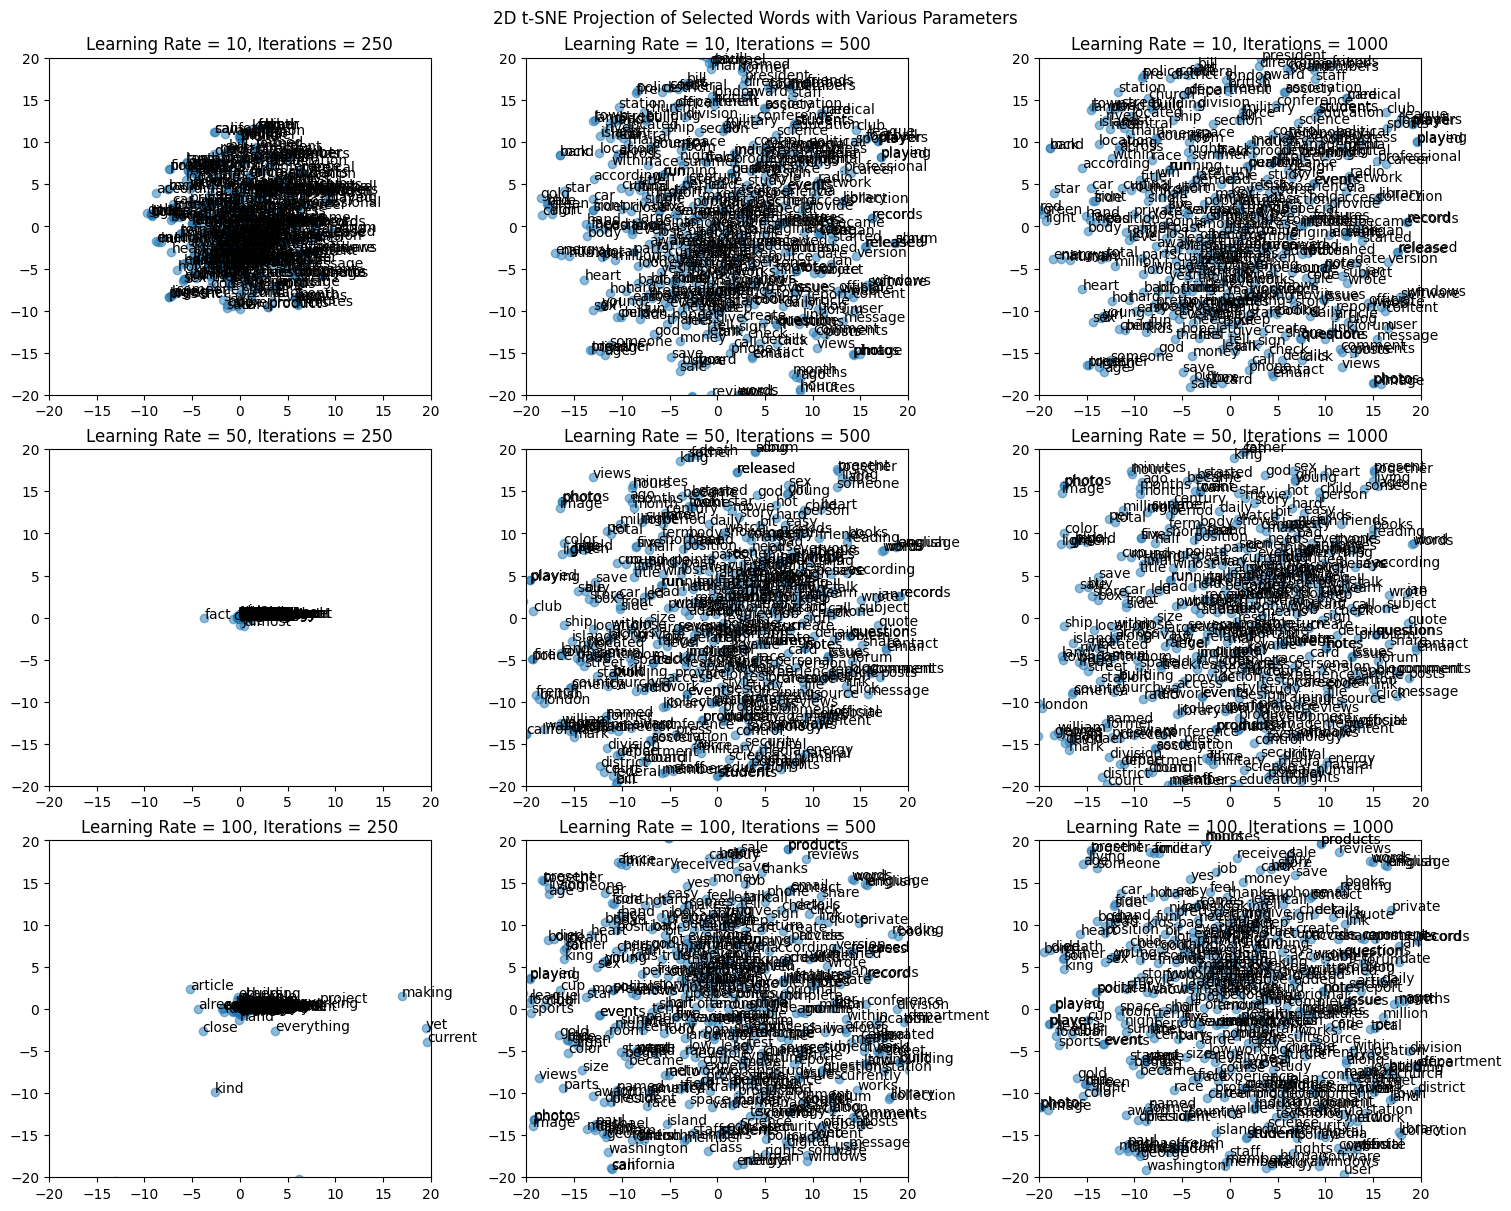

In [ ]:
learning_rates = [10, 50, 100]
n_iter_values = [250, 500, 1000]

# Create a figure for the subplots, adjusting subplot layout
num_lr = len(learning_rates)
num_iter = len(n_iter_values)
fig, axes = plt.subplots(num_lr, num_iter, figsize=(15, 12),
                         constrained_layout=True)

# Iterate over learning rates and iteration values
for i, lr in enumerate(learning_rates):
    for j, n_iter in enumerate(n_iter_values):
        # Use PCA to project countries and capitals into 2D
        tsne = TSNE(n_components=2, learning_rate=lr, n_iter=n_iter, random_state=42)
        selected_vecs_2d = tsne.fit_transform(word2vec_en.vec[top_inds])

        # Plot the t-SNE projection
        ax = axes[i, j]
        ax.scatter(selected_vecs_2d[:, 0], selected_vecs_2d[:, 1], alpha=0.5)

        # Annotate each point with the corresponding word
        for k, word in enumerate(top_words):
            ax.annotate(word, (selected_vecs_2d[k, 0], selected_vecs_2d[k, 1]))

        ax.set_title(f'Learning Rate = {lr}, Iterations = {n_iter}')
        ax.set_xlim([-20, 20])
        ax.set_ylim([-20, 20])

# Add a common title and adjust subplot layout
plt.suptitle('2D t-SNE Projection of Selected Words with Various Parameters')
plt.show()


# <span style="color: Red;">**Discussion:**:</span>
From the t-SNE visualizations with various perplexities and learning rates, I can discern that the choice of parameters has a substantial impact on the formation of clusters within the high-dimensional word embeddings space. When the perplexity is lower, clusters are more distinct but potentiall over fitted to local structures, whereas higher perplexity values lead to more global groupings but can also cause the clusters to overlap. Similarly, different learning rates and numbers of iterations during t-SNE optimization significantly influence the clarity and separation of clusters. A lower learning rate with sufficient iterations tends to produce more defined clusters, while too high a learning rate or insufficient iterations can result in either a dense, overlapped projection or an under-optimized layout with too much spread.

I observed that there is a balance to be struck when selecting t-SNE parameters: the perplexity should be high enough to capture broader data relationships without sacrificing local similarity, and the learning rate must be tuned to allow the gradient descent to adequately converge to a meaningful low-dimensional representation.